In [1]:
from qiskit import QuantumCircuit,ClassicalRegister,QuantumRegister
from qiskit import Aer,execute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.visualization import plot_histogram

In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00...0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    #Apply transformation |00...0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multicontrolled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)),nqubits-1)
    qc.h(nqubits-1)
    
    #Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |11...1> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [3]:
c_eff = [[0,1,2],
         [1,0,3],
         [2,0,3],
         [3,1,2]]

In [4]:
def lights_out_oracle(qc,cf,c_reg,eff_reg,anci,cls):
    # compute
    for ce in c_eff:
        qc.cx(ce,eff_reg[ce[0]])
        
    # mct
    qc.mcx(eff_reg,output_reg,anci,mode='basic')
    
    # uncompute
    for ce in c_eff:
        qc.cx(ce,eff_reg[ce[0]])

In [5]:
def add_iter(qc,cf,c_reg,eff_reg,anci,cls):
    lights_out_oracle(qc,cf,c_reg,eff_reg,anci,cls)
    qc.barrier()
    qc.append(diffuser(n),c_reg)

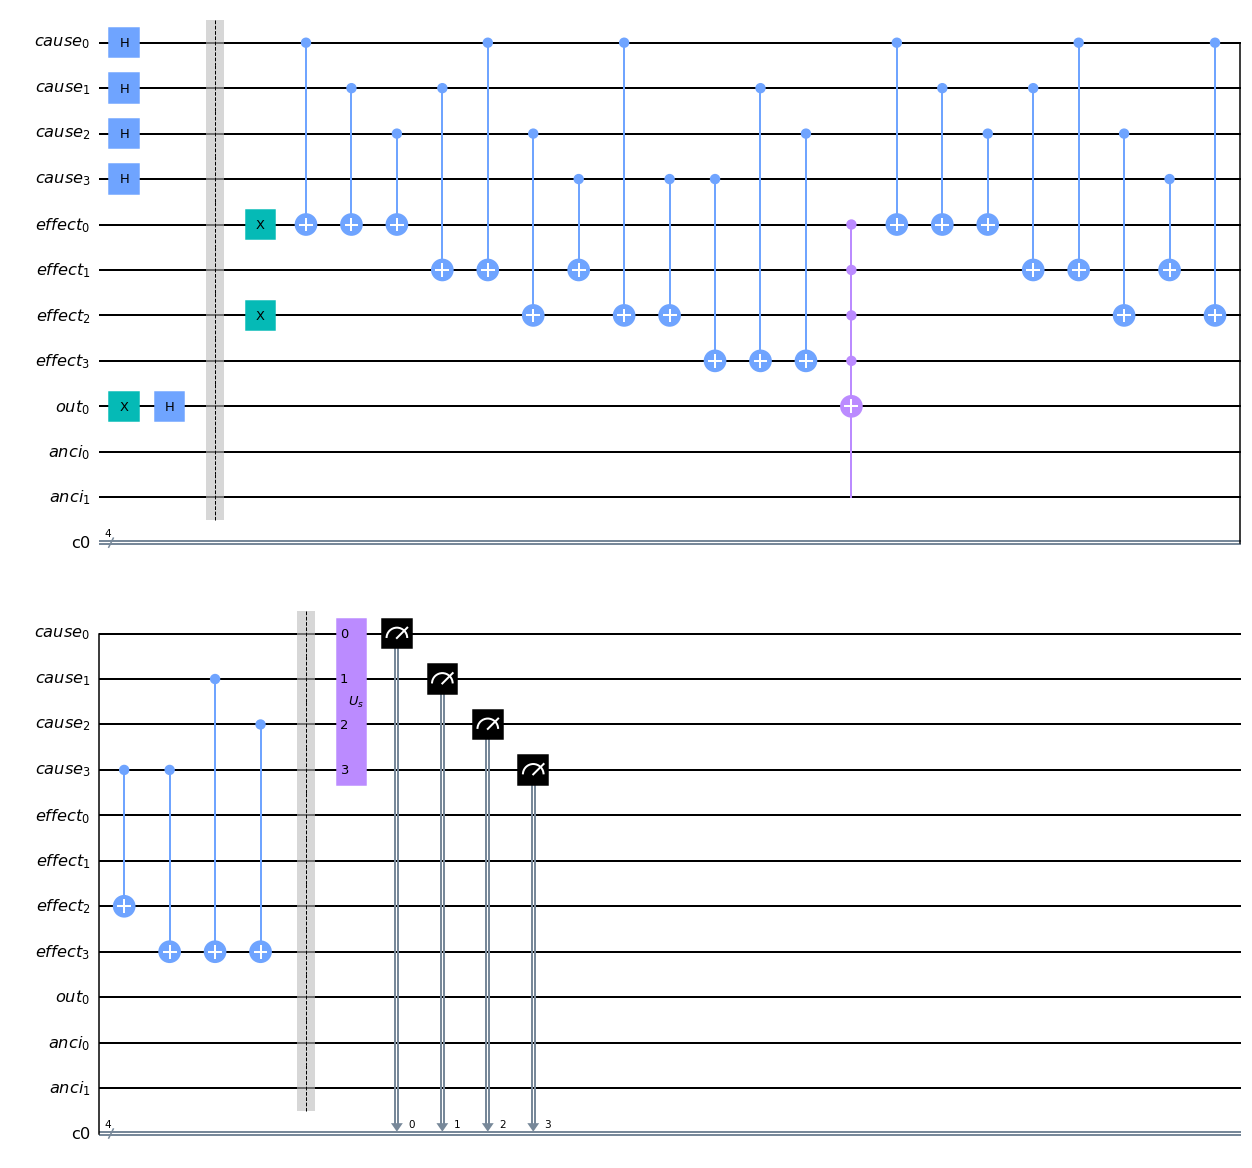

In [6]:
# Construct the circuit for 2x2 lights out board
n = 4
# initial state of board
lights = [0,1,0,1]
# cause_reg ---> contains possible solution states. "Causes" the state of board to change
# effect_reg --> contains the tiles of the board on which the cause_reg acts
# output_reg --> qubit in the |-> state for "marking" the solution
# ancilla -----> for using with mct in order to reduce cost.
# cbits -------> classical bits for storing the solution when read.
cause_reg = QuantumRegister(n,name='cause')
effect_reg = QuantumRegister(n,name='effect')
output_reg = QuantumRegister(1,name='out')
ancilla = QuantumRegister(n-2,name='anci')
cbits = ClassicalRegister(n)

# circuit
quc = QuantumCircuit(cause_reg,effect_reg,output_reg,ancilla,cbits)

# initialize all possible solutions
quc.h(cause_reg)
# initialize |->
quc.x(output_reg)
quc.h(output_reg)

quc.barrier()
for l in range(n):
    if lights[l] is 0:
        quc.x(effect_reg[l])
# add 1 iteration of oracle and diffuser
add_iter(quc,c_eff,cause_reg,effect_reg,ancilla,cbits)

quc.measure(cause_reg,cbits)

quc.draw('mpl')

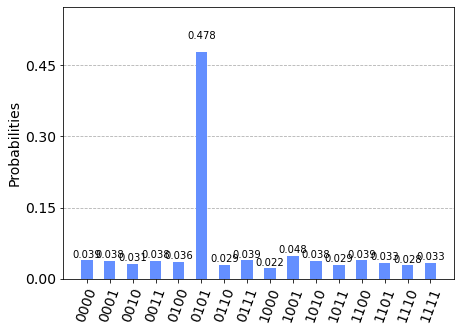

In [7]:
qasm_sim = Aer.get_backend('qasm_simulator')
res = execute(quc,backend = qasm_sim,shots = 1024).result()
ans = res.get_counts()
plot_histogram(ans)